In [25]:
# Import libraries
import os
import sys
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report

In [26]:
!gdown 1BL-ew2zg6anD6gEGJb2aM2qWHf58mPPB

Downloading...
From: https://drive.google.com/uc?id=1BL-ew2zg6anD6gEGJb2aM2qWHf58mPPB
To: /content/stock_price.csv
100% 109k/109k [00:00<00:00, 73.5MB/s]


In [27]:
stock_data = pd.read_csv('stock_price.csv')
stock_data.head()

,Date,Closing,Volume,Opening,Highest,Lowest,Symbol,Close,Open,High,Low
0,08-07-2020,$111.1125,198045600,$113.205,$113.675,$110.2925,AAPL,111.1125,113.2050,113.6750,110.2925
1,08-10-2020,$112.7275,212403440,$112.60,$113.775,$110.00,AAPL,112.7275,112.6000,113.7750,110.0000
2,08-11-2020,$109.375,187902360,$111.9688,$112.4825,$109.1067,AAPL,109.3750,111.9688,112.4825,109.1067
3,08-12-2020,$113.01,165944840,$110.4975,$113.275,$110.2975,AAPL,113.0100,110.4975,113.2750,110.2975
4,08/13/2020,$115.01,210082080,$114.43,$116.0425,$113.9275,AAPL,115.0100,114.4300,116.0425,113.9275


In [28]:
stock_data = stock_data[['Symbol','Date','Close','High','Low','Open','Volume']]
stock_data.head()

,Symbol,Date,Close,High,Low,Open,Volume
0,AAPL,08-07-2020,111.1125,113.6750,110.2925,113.2050,198045600
1,AAPL,08-10-2020,112.7275,113.7750,110.0000,112.6000,212403440
2,AAPL,08-11-2020,109.3750,112.4825,109.1067,111.9688,187902360
3,AAPL,08-12-2020,113.0100,113.2750,110.2975,110.4975,165944840
4,AAPL,08/13/2020,115.0100,116.0425,113.9275,114.4300,210082080


In [29]:
stock_data['Price_Change'] = stock_data['Close'].diff()
stock_data

,Symbol,Date,Close,High,Low,Open,Volume,Price_Change
0,AAPL,08-07-2020,111.1125,113.6750,110.2925,113.2050,198045600,NaN
1,AAPL,08-10-2020,112.7275,113.7750,110.0000,112.6000,212403440,1.6150
2,AAPL,08-11-2020,109.3750,112.4825,109.1067,111.9688,187902360,-3.3525
3,AAPL,08-12-2020,113.0100,113.2750,110.2975,110.4975,165944840,3.6350
4,AAPL,08/13/2020,115.0100,116.0425,113.9275,114.4300,210082080,2.0000
...,...,...,...,...,...,...,...,...
1250,AAPL,07/31/2025,207.5700,209.8400,207.1600,208.4900,80698430,-1.4800
1251,AAPL,08-01-2025,202.3800,213.5800,201.5000,210.8650,104434500,-5.1900
1252,AAPL,08-04-2025,203.3500,207.8800,201.6750,204.5050,75109300,0.9700
1253,AAPL,08-05-2025,202.9200,205.3400,202.1600,203.4000,44155080,-0.4300


In [30]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = stock_data[['Symbol','Price_Change']].copy(), stock_data[['Symbol','Price_Change']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['Price_Change'] = up_df.loc[(up_df['Price_Change'] < 0), 'Price_Change'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['Price_Change'] = down_df.loc[(down_df['Price_Change'] > 0), 'Price_Change'] = 0

# We need change in price to be absolute.
down_df['Price_Change'] = down_df['Price_Change'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('Symbol')['Price_Change'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Symbol')['Price_Change'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
stock_data['down_days'] = down_df['Price_Change']
stock_data['up_days'] = up_df['Price_Change']
stock_data['RSI'] = relative_strength_index

# Display the head.
stock_data.head(30)

,Symbol,Date,Close,High,Low,Open,Volume,Price_Change,down_days,up_days,RSI
0,AAPL,08-07-2020,111.1125,113.6750,110.2925,113.2050,198045600,NaN,NaN,NaN,NaN
1,AAPL,08-10-2020,112.7275,113.7750,110.0000,112.6000,212403440,1.6150,0.0000,1.6150,100.000000
2,AAPL,08-11-2020,109.3750,112.4825,109.1067,111.9688,187902360,-3.3525,3.3525,0.0000,29.453232
3,AAPL,08-12-2020,113.0100,113.2750,110.2975,110.4975,165944840,3.6350,0.0000,3.6350,62.526816
4,AAPL,08/13/2020,115.0100,116.0425,113.9275,114.4300,210082080,2.0000,0.0000,2.0000,71.121840
5,AAPL,08/14/2020,114.9075,115.0000,113.0450,114.8288,165565200,-0.1025,0.1025,0.0000,70.170096
6,AAPL,08/17/2020,114.6075,116.0875,113.9625,116.0625,119561440,-0.3000,0.3000,0.0000,67.136075
7,AAPL,08/18/2020,115.5625,116.0000,114.0075,114.3525,105633560,0.9550,0.0000,0.9550,71.640104
8,AAPL,08/19/2020,115.7075,117.1625,115.6100,115.9833,145538000,0.1450,0.0000,0.1450,72.305063
9,AAPL,08/20/2020,118.2750,118.3920,115.7334,115.7500,126907200,2.5675,0.0000,2.5675,81.275180


In [31]:
# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = stock_data[['Symbol','Low']].copy(), stock_data[['Symbol','High']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('Symbol')['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Symbol')['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((stock_data['Close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
stock_data['low_14'] = low_14
stock_data['high_14'] = high_14
stock_data['k_percent'] = k_percent

# Display the head.
stock_data.head(30)

,Symbol,Date,Close,High,Low,Open,Volume,Price_Change,down_days,up_days,RSI,low_14,high_14,k_percent
0,AAPL,08-07-2020,111.1125,113.6750,110.2925,113.2050,198045600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,08-10-2020,112.7275,113.7750,110.0000,112.6000,212403440,1.6150,0.0000,1.6150,100.000000,NaN,NaN,NaN
2,AAPL,08-11-2020,109.3750,112.4825,109.1067,111.9688,187902360,-3.3525,3.3525,0.0000,29.453232,NaN,NaN,NaN
3,AAPL,08-12-2020,113.0100,113.2750,110.2975,110.4975,165944840,3.6350,0.0000,3.6350,62.526816,NaN,NaN,NaN
4,AAPL,08/13/2020,115.0100,116.0425,113.9275,114.4300,210082080,2.0000,0.0000,2.0000,71.121840,NaN,NaN,NaN
5,AAPL,08/14/2020,114.9075,115.0000,113.0450,114.8288,165565200,-0.1025,0.1025,0.0000,70.170096,NaN,NaN,NaN
6,AAPL,08/17/2020,114.6075,116.0875,113.9625,116.0625,119561440,-0.3000,0.3000,0.0000,67.136075,NaN,NaN,NaN
7,AAPL,08/18/2020,115.5625,116.0000,114.0075,114.3525,105633560,0.9550,0.0000,0.9550,71.640104,NaN,NaN,NaN
8,AAPL,08/19/2020,115.7075,117.1625,115.6100,115.9833,145538000,0.1450,0.0000,0.1450,72.305063,NaN,NaN,NaN
9,AAPL,08/20/2020,118.2750,118.3920,115.7334,115.7500,126907200,2.5675,0.0000,2.5675,81.275180,NaN,NaN,NaN


In [32]:
# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = stock_data[['Symbol','Low']].copy(), stock_data[['Symbol','High']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('Symbol')['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('Symbol')['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - stock_data['Close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
stock_data['r_percent'] = r_percent

# Display the head.
stock_data.head(30)

,Symbol,Date,Close,High,Low,Open,Volume,Price_Change,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
0,AAPL,08-07-2020,111.1125,113.6750,110.2925,113.2050,198045600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,08-10-2020,112.7275,113.7750,110.0000,112.6000,212403440,1.6150,0.0000,1.6150,100.000000,NaN,NaN,NaN,NaN
2,AAPL,08-11-2020,109.3750,112.4825,109.1067,111.9688,187902360,-3.3525,3.3525,0.0000,29.453232,NaN,NaN,NaN,NaN
3,AAPL,08-12-2020,113.0100,113.2750,110.2975,110.4975,165944840,3.6350,0.0000,3.6350,62.526816,NaN,NaN,NaN,NaN
4,AAPL,08/13/2020,115.0100,116.0425,113.9275,114.4300,210082080,2.0000,0.0000,2.0000,71.121840,NaN,NaN,NaN,NaN
5,AAPL,08/14/2020,114.9075,115.0000,113.0450,114.8288,165565200,-0.1025,0.1025,0.0000,70.170096,NaN,NaN,NaN,NaN
6,AAPL,08/17/2020,114.6075,116.0875,113.9625,116.0625,119561440,-0.3000,0.3000,0.0000,67.136075,NaN,NaN,NaN,NaN
7,AAPL,08/18/2020,115.5625,116.0000,114.0075,114.3525,105633560,0.9550,0.0000,0.9550,71.640104,NaN,NaN,NaN,NaN
8,AAPL,08/19/2020,115.7075,117.1625,115.6100,115.9833,145538000,0.1450,0.0000,0.1450,72.305063,NaN,NaN,NaN,NaN
9,AAPL,08/20/2020,118.2750,118.3920,115.7334,115.7500,126907200,2.5675,0.0000,2.5675,81.275180,NaN,NaN,NaN,NaN


In [33]:
# Calculate the MACD
ema_26 = stock_data.groupby('Symbol')['Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = stock_data.groupby('Symbol')['Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
stock_data['MACD'] = macd
stock_data['MACD_EMA'] = ema_9_macd

# Print the head.
stock_data.head(30)

,Symbol,Date,Close,High,Low,Open,Volume,Price_Change,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
0,AAPL,08-07-2020,111.1125,113.6750,110.2925,113.2050,198045600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,AAPL,08-10-2020,112.7275,113.7750,110.0000,112.6000,212403440,1.6150,0.0000,1.6150,100.000000,NaN,NaN,NaN,NaN,0.036234,0.020130
2,AAPL,08-11-2020,109.3750,112.4825,109.1067,111.9688,187902360,-3.3525,3.3525,0.0000,29.453232,NaN,NaN,NaN,NaN,-0.057792,-0.011805
3,AAPL,08-12-2020,113.0100,113.2750,110.2975,110.4975,165944840,3.6350,0.0000,3.6350,62.526816,NaN,NaN,NaN,NaN,0.032100,0.003068
4,AAPL,08/13/2020,115.0100,116.0425,113.9275,114.4300,210082080,2.0000,0.0000,2.0000,71.121840,NaN,NaN,NaN,NaN,0.159855,0.049709
5,AAPL,08/14/2020,114.9075,115.0000,113.0450,114.8288,165565200,-0.1025,0.1025,0.0000,70.170096,NaN,NaN,NaN,NaN,0.229265,0.098379
6,AAPL,08/17/2020,114.6075,116.0875,113.9625,116.0625,119561440,-0.3000,0.3000,0.0000,67.136075,NaN,NaN,NaN,NaN,0.256239,0.138329
7,AAPL,08/18/2020,115.5625,116.0000,114.0075,114.3525,105633560,0.9550,0.0000,0.9550,71.640104,NaN,NaN,NaN,NaN,0.315626,0.180937
8,AAPL,08/19/2020,115.7075,117.1625,115.6100,115.9833,145538000,0.1450,0.0000,0.1450,72.305063,NaN,NaN,NaN,NaN,0.359141,0.222103
9,AAPL,08/20/2020,118.2750,118.3920,115.7334,115.7500,126907200,2.5675,0.0000,2.5675,81.275180,NaN,NaN,NaN,NaN,0.517035,0.288185


In [34]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
stock_data['Price_Rate_Of_Change'] = stock_data.groupby('Symbol')['Close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
stock_data.head(30)

,Symbol,Date,Close,High,Low,Open,Volume,Price_Change,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
0,AAPL,08-07-2020,111.1125,113.6750,110.2925,113.2050,198045600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,AAPL,08-10-2020,112.7275,113.7750,110.0000,112.6000,212403440,1.6150,0.0000,1.6150,100.000000,NaN,NaN,NaN,NaN,0.036234,0.020130,NaN
2,AAPL,08-11-2020,109.3750,112.4825,109.1067,111.9688,187902360,-3.3525,3.3525,0.0000,29.453232,NaN,NaN,NaN,NaN,-0.057792,-0.011805,NaN
3,AAPL,08-12-2020,113.0100,113.2750,110.2975,110.4975,165944840,3.6350,0.0000,3.6350,62.526816,NaN,NaN,NaN,NaN,0.032100,0.003068,NaN
4,AAPL,08/13/2020,115.0100,116.0425,113.9275,114.4300,210082080,2.0000,0.0000,2.0000,71.121840,NaN,NaN,NaN,NaN,0.159855,0.049709,NaN
5,AAPL,08/14/2020,114.9075,115.0000,113.0450,114.8288,165565200,-0.1025,0.1025,0.0000,70.170096,NaN,NaN,NaN,NaN,0.229265,0.098379,NaN
6,AAPL,08/17/2020,114.6075,116.0875,113.9625,116.0625,119561440,-0.3000,0.3000,0.0000,67.136075,NaN,NaN,NaN,NaN,0.256239,0.138329,NaN
7,AAPL,08/18/2020,115.5625,116.0000,114.0075,114.3525,105633560,0.9550,0.0000,0.9550,71.640104,NaN,NaN,NaN,NaN,0.315626,0.180937,NaN
8,AAPL,08/19/2020,115.7075,117.1625,115.6100,115.9833,145538000,0.1450,0.0000,0.1450,72.305063,NaN,NaN,NaN,NaN,0.359141,0.222103,NaN
9,AAPL,08/20/2020,118.2750,118.3920,115.7334,115.7500,126907200,2.5675,0.0000,2.5675,81.275180,NaN,NaN,NaN,NaN,0.517035,0.288185,0.064462


In [35]:
def obv(group):

    # Grab the volume and close column.
    volume = group['Volume']
    change = group['Close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate the On Balance Volume
    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)

    # Return a panda series.
    return pd.Series(obv_values, index = group.index)

In [36]:
# apply the function to each group
obv_groups = stock_data.groupby('Symbol').apply(obv, include_groups=False)

# The `obv_groups` DataFrame currently has the 'Symbol' as the index and the OBV values
# spread across columns with numeric indices. To assign it to a single column in `stock_data`,
# we need to extract the single row for 'AAPL' as a Series.
stock_data['OBV'] = obv_groups.loc['AAPL']

# display the data frame.
stock_data.head(30)

,Symbol,Date,Close,High,Low,Open,Volume,Price_Change,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,OBV
0,AAPL,08-07-2020,111.1125,113.6750,110.2925,113.2050,198045600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0
1,AAPL,08-10-2020,112.7275,113.7750,110.0000,112.6000,212403440,1.6150,0.0000,1.6150,100.000000,NaN,NaN,NaN,NaN,0.036234,0.020130,NaN,212403440
2,AAPL,08-11-2020,109.3750,112.4825,109.1067,111.9688,187902360,-3.3525,3.3525,0.0000,29.453232,NaN,NaN,NaN,NaN,-0.057792,-0.011805,NaN,24501080
3,AAPL,08-12-2020,113.0100,113.2750,110.2975,110.4975,165944840,3.6350,0.0000,3.6350,62.526816,NaN,NaN,NaN,NaN,0.032100,0.003068,NaN,190445920
4,AAPL,08/13/2020,115.0100,116.0425,113.9275,114.4300,210082080,2.0000,0.0000,2.0000,71.121840,NaN,NaN,NaN,NaN,0.159855,0.049709,NaN,400528000
5,AAPL,08/14/2020,114.9075,115.0000,113.0450,114.8288,165565200,-0.1025,0.1025,0.0000,70.170096,NaN,NaN,NaN,NaN,0.229265,0.098379,NaN,234962800
6,AAPL,08/17/2020,114.6075,116.0875,113.9625,116.0625,119561440,-0.3000,0.3000,0.0000,67.136075,NaN,NaN,NaN,NaN,0.256239,0.138329,NaN,115401360
7,AAPL,08/18/2020,115.5625,116.0000,114.0075,114.3525,105633560,0.9550,0.0000,0.9550,71.640104,NaN,NaN,NaN,NaN,0.315626,0.180937,NaN,221034920
8,AAPL,08/19/2020,115.7075,117.1625,115.6100,115.9833,145538000,0.1450,0.0000,0.1450,72.305063,NaN,NaN,NaN,NaN,0.359141,0.222103,NaN,366572920
9,AAPL,08/20/2020,118.2750,118.3920,115.7334,115.7500,126907200,2.5675,0.0000,2.5675,81.275180,NaN,NaN,NaN,NaN,0.517035,0.288185,0.064462,493480120


In [37]:
close_groups = stock_data['Close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe.
stock_data['Prediction'] = close_groups

# for simplicity in later sections I'm going to make a change to our prediction column. To keep this as a binary classifier I'll change flat days and consider them up days.
stock_data.loc[stock_data['Prediction'] == 0.0] = 1.0

# print the head
stock_data.head(50)

,Symbol,Date,Close,High,Low,Open,Volume,Price_Change,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,OBV,Prediction
0,AAPL,08-07-2020,111.1125,113.6750,110.2925,113.2050,198045600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0,NaN
1,AAPL,08-10-2020,112.7275,113.7750,110.0000,112.6000,212403440,1.6150,0.0000,1.6150,100.000000,NaN,NaN,NaN,NaN,0.036234,0.020130,NaN,212403440,1.0
2,AAPL,08-11-2020,109.3750,112.4825,109.1067,111.9688,187902360,-3.3525,3.3525,0.0000,29.453232,NaN,NaN,NaN,NaN,-0.057792,-0.011805,NaN,24501080,-1.0
3,AAPL,08-12-2020,113.0100,113.2750,110.2975,110.4975,165944840,3.6350,0.0000,3.6350,62.526816,NaN,NaN,NaN,NaN,0.032100,0.003068,NaN,190445920,1.0
4,AAPL,08/13/2020,115.0100,116.0425,113.9275,114.4300,210082080,2.0000,0.0000,2.0000,71.121840,NaN,NaN,NaN,NaN,0.159855,0.049709,NaN,400528000,1.0
5,AAPL,08/14/2020,114.9075,115.0000,113.0450,114.8288,165565200,-0.1025,0.1025,0.0000,70.170096,NaN,NaN,NaN,NaN,0.229265,0.098379,NaN,234962800,-1.0
6,AAPL,08/17/2020,114.6075,116.0875,113.9625,116.0625,119561440,-0.3000,0.3000,0.0000,67.136075,NaN,NaN,NaN,NaN,0.256239,0.138329,NaN,115401360,-1.0
7,AAPL,08/18/2020,115.5625,116.0000,114.0075,114.3525,105633560,0.9550,0.0000,0.9550,71.640104,NaN,NaN,NaN,NaN,0.315626,0.180937,NaN,221034920,1.0
8,AAPL,08/19/2020,115.7075,117.1625,115.6100,115.9833,145538000,0.1450,0.0000,0.1450,72.305063,NaN,NaN,NaN,NaN,0.359141,0.222103,NaN,366572920,1.0
9,AAPL,08/20/2020,118.2750,118.3920,115.7334,115.7500,126907200,2.5675,0.0000,2.5675,81.275180,NaN,NaN,NaN,NaN,0.517035,0.288185,0.064462,493480120,1.0


In [38]:
# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(stock_data.shape[0], stock_data.shape[1]))

stock_data = stock_data.dropna()

print('After NaN Drop we have {} rows and {} columns'.format(stock_data.shape[0], stock_data.shape[1]))
stock_data.head()

Before NaN Drop we have 1255 rows and 20 columns
After NaN Drop we have 1242 rows and 20 columns


,Symbol,Date,Close,High,Low,Open,Volume,Price_Change,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,OBV,Prediction
13,AAPL,08/26/2020,126.5225,126.9925,125.0825,126.1793,163022280,1.6975,0.0000,1.6975,85.742173,109.1067,128.785,88.502564,-11.497436,1.778725,1.020823,0.100100,1128999000,1.0
14,AAPL,08/27/2020,125.0100,127.4850,123.8325,127.1425,155552400,-1.5125,1.5125,0.0000,74.972785,109.1067,128.785,80.816432,-19.183568,1.843703,1.191400,0.087919,973446600,-1.0
15,AAPL,08/28/2020,124.8075,126.4425,124.5775,126.0125,187629920,-0.2025,0.2025,0.0000,73.545759,109.1067,128.785,79.787380,-20.212620,1.857552,1.328490,0.088999,785816680,-1.0
16,AAPL,08/31/2020,129.0400,131.0000,126.0000,127.5800,225702700,4.2325,0.0000,4.2325,81.868701,110.2975,131.000,90.532544,-9.467456,2.106989,1.487776,0.116625,1011519380,1.0
17,AAPL,09-01-2020,134.1800,134.8000,130.5300,132.7600,152470100,5.1400,0.0000,5.1400,87.416291,113.0450,134.800,97.150080,-2.849920,2.596228,1.713533,0.159648,1163989480,1.0


In [39]:
X_Cols = stock_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','OBV']]
Y_Cols = stock_data['Prediction']

# Split X and y. KEEP SHUFFLE AS FALSE to avoid data leakage
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X_Cols, Y_Cols, random_state=0, shuffle=False, test_size=0.1)

X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, random_state=0, shuffle=False, test_size=0.1)

In [40]:
# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Validate on dev set
y_val = rand_frst_clf.predict(X_dev)

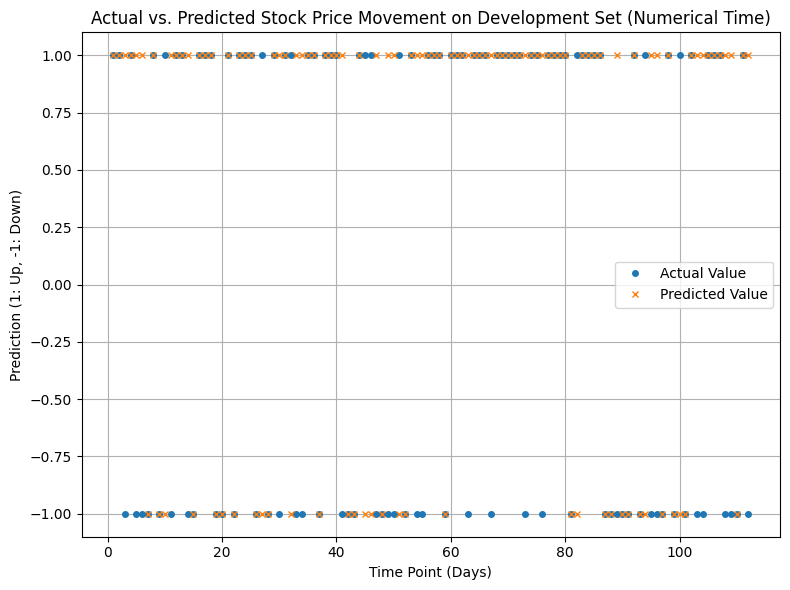

In [41]:
time_points = range(1, len(y_dev) + 1)

plt.figure(figsize=(8, 6))
plt.plot(time_points, y_dev, label='Actual Value', marker='o', linestyle='', markersize=4)
plt.plot(time_points, y_val, label='Predicted Value', marker='x', linestyle='', markersize=4)
plt.xlabel('Time Point (Days)')
plt.ylabel('Prediction (1: Up, -1: Down)')
plt.title('Actual vs. Predicted Stock Price Movement on Development Set (Numerical Time)')
plt.tight_layout()
plt.legend()
plt.grid(True)
plt.show()

In [42]:
print('Correct Prediction (%): ', accuracy_score(y_dev, y_val, normalize = True) * 100.0)

Correct Prediction (%):  68.75


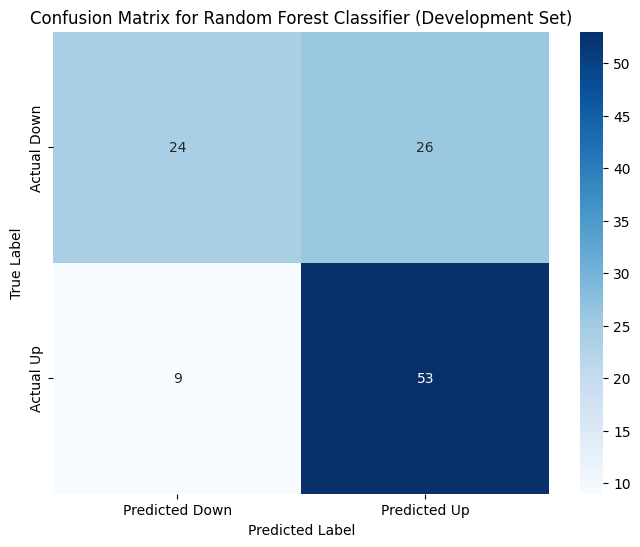

In [43]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_dev, y_val)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Down', 'Predicted Up'], yticklabels=['Actual Down', 'Actual Up'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Classifier (Development Set)')
plt.show()

###Feature Importance

In [44]:
feature_importances = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns)
sorted_feature_importances = feature_importances.sort_values(ascending=False)
print(sorted_feature_importances)

k_percent               0.197576
r_percent               0.192773
RSI                     0.178481
Price_Rate_Of_Change    0.160392
MACD                    0.151381
OBV                     0.119397
dtype: float64


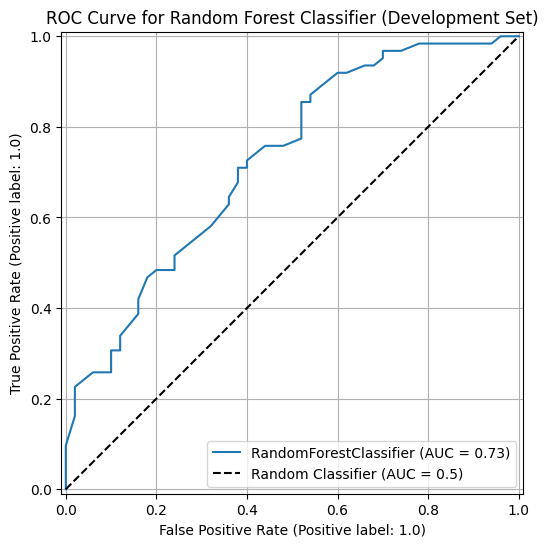

In [45]:
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(rand_frst_clf, X_dev, y_dev, ax=plt.gca())
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')
plt.title('ROC Curve for Random Forest Classifier (Development Set)')
plt.grid(True)
plt.legend()
plt.show()

###Hyperparameter tuning

In [46]:
#List the parameters
max_depth = list(range(10, 110, 10))
max_depth.append(None)

parameters = {'n_estimators': list(range(200, 1000, 100)),
               'max_features': [None, 'sqrt', 'log2'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10, 20, 30, 40],
               'min_samples_leaf': [1, 2, 7, 12, 14, 16 ,20],
               'bootstrap': [True, False]}
print(f"params grid : {parameters}")

params grid : {'n_estimators': [200, 300, 400, 500, 600, 700, 800, 900], 'max_features': [None, 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}


In [47]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = parameters, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train_dev, y_train_dev)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 7, 12, 14,
                                                             16, 20],
                                        'min_samples_split': [2, 5, 10, 20, 30,
                                                              40],
                                        'n_estimators': [200, 300, 400, 500,
                                                         600, 700, 800, 900]},
                   random_state=42, verbose=2)

In [48]:
best_estimators = rf_random.best_estimator_
print(best_estimators)

RandomForestClassifier(max_depth=30, max_features='log2', min_samples_leaf=20,
                       min_samples_split=20, n_estimators=700)


In [49]:
y_pred = rf_random.predict(X_test)
print('Correct Prediction (%): ', accuracy_score(y_test, y_pred, normalize = True) * 100.0)

Correct Prediction (%):  73.6


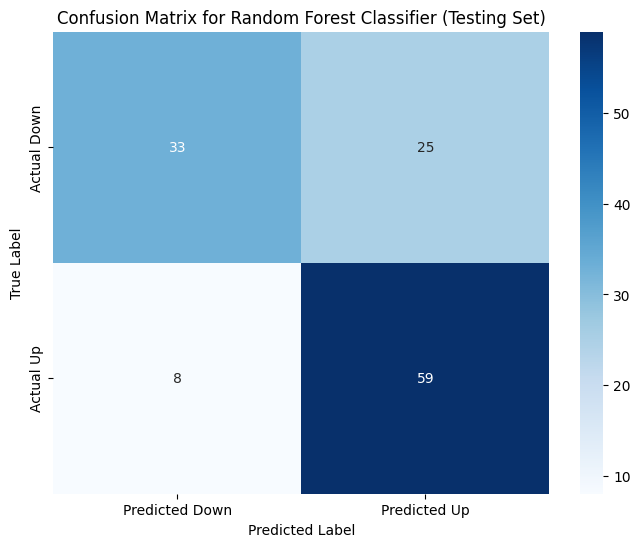

In [50]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Down', 'Predicted Up'], yticklabels=['Actual Down', 'Actual Up'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Classifier (Testing Set)')
plt.show()

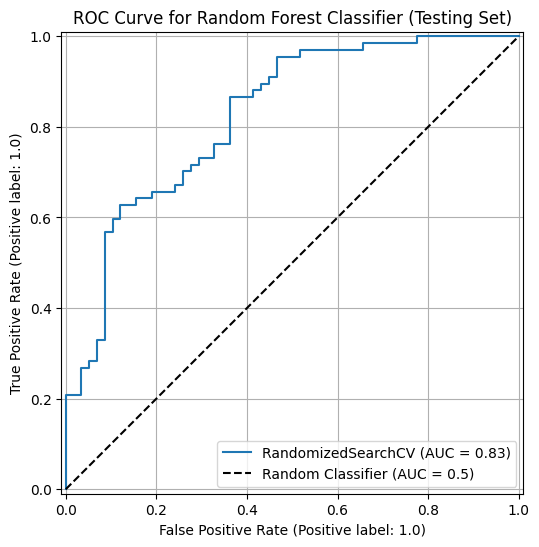

In [51]:
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(rf_random, X_test, y_test, ax=plt.gca())
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')
plt.title('ROC Curve for Random Forest Classifier (Testing Set)')
plt.grid(True)
plt.legend()
plt.show()